# 資金繰りリスク可視化ツール Phase 1
## 資金ショート確率シミュレーター

---

### このツールで何ができるか

**天気予報と同じ考え方で、会社のお金が尽きる確率を計算します。**

- 🌧️ 天気予報：「明日の降水確率は70%」
- 💰 このツール：「3ヶ月以内に資金ショートする確率は15%」

### 使い方（5分でできます）

1. セル3の `パラメータ設定` に自社の数字を入力
2. 上のメニューから「Kernel」→「Restart & Run All」
3. グラフとレポートを確認
4. グラフは自動的にPNGファイルで保存されます

### 技術的な説明（社長には不要。興味ある方だけ）

**モンテカルロ法**（Monte Carlo Method）を使っています。
10,000通りの「ありえる未来」をコンピュータで計算し、
そのうち何通りで資金ショートが起きるかを数えます。
気象予報士がスーパーコンピュータで使う手法と同じ原理です。

---

**開発者:** T社 金融実務経験20年  
**バージョン:** Phase 1.1（完全日本語版）  
**作成日:** 2026年2月

In [1]:
# ============================================================
# セル1: ライブラリのインポートと日本語フォント設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from dataclasses import dataclass
from typing import Optional, Tuple
import warnings
import os
from pathlib import Path

# 日本語フォントの自動検出と設定
def setup_japanese_font():
    """日本語が表示できるフォントを自動検出して設定する"""
    import matplotlib.font_manager as fm
    
    # Windows環境で利用可能な日本語フォントリスト（優先順）
    japanese_fonts = [
        'MS Gothic',      # MSゴシック
        'Yu Gothic',      # 游ゴシック  
        'Meiryo',         # メイリオ
        'MS PGothic',     # MS Pゴシック
        'BIZ UDGothic',   # BIZ UDゴシック
    ]
    
    # 利用可能なフォント名を取得
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 優先順位で日本語フォントを探す
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            print(f"✅ 日本語フォント設定: {font}")
            return font
    
    # 見つからない場合はデフォルト
    print("⚠️  日本語フォントが見つかりません。一部文字化けする可能性があります。")
    return None

# フォント設定実行
setup_japanese_font()

# その他のグラフ設定
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け防止

# 乱数の固定（再現性確保）
np.random.seed(42)

# 保存先フォルダの設定
# ノートブックと同じフォルダに保存
OUTPUT_DIR = Path.cwd()  # 現在のフォルダ
print(f"✅ グラフ保存先: {OUTPUT_DIR}")
print(f"✅ NumPy バージョン: {np.__version__}")
print(f"✅ Matplotlib バージョン: {plt.matplotlib.__version__}")

✅ 日本語フォント設定: MS Gothic
✅ グラフ保存先: C:\Users\TSR\Desktop\CFMプログラム
✅ NumPy バージョン: 2.3.5
✅ Matplotlib バージョン: 3.10.6


In [2]:
# ============================================================
# セル2: パラメータクラスの定義
# ============================================================

@dataclass
class CashFlowParameters:
    """
    資金繰りシミュレーションのパラメータ（設定値）を管理するクラス。
    
    【使い方】
    params = CashFlowParameters(
        monthly_sales=1000,    # 月次売上1,000万円
        cash_balance=500,      # 現金残高500万円
        monthly_fixed_cost=600,# 固定費600万円/月
        cost_rate=0.60,        # 原価率60%
    )
    
    Parameters（入力項目）
    ----------
    monthly_sales : float
        月次平均売上（万円）。過去3〜6ヶ月の平均を入れてください。
    sales_volatility : float
        売上変動率（0〜1の小数）。例: 15%なら0.15。
        わからなければデフォルトの0.15（15%）のままでOK。
    cash_balance : float
        現在の現金・預金残高（万円）。今日時点の通帳残高。
    monthly_fixed_cost : float
        月次固定費（万円）。家賃・人件費・リース料など売上に関係なく
        出ていく費用の合計。
    cost_rate : float
        売上原価率（0〜1の小数）。例: 原価率60%なら0.60。
    accounts_receivable_days : int
        売掛サイト（日数）。売上が現金になるまでの日数。
    simulation_months : int
        シミュレーション期間（ヶ月）。
    num_simulations : int
        シミュレーション回数。多いほど精度UP。推奨10,000。
    """
    
    monthly_sales: float
    cash_balance: float
    monthly_fixed_cost: float
    cost_rate: float
    sales_volatility: float = 0.15
    accounts_receivable_days: int = 30
    simulation_months: int = 12
    num_simulations: int = 10000
    
    def validate(self) -> None:
        """入力値の妥当性チェック"""
        if self.monthly_sales <= 0:
            raise ValueError(f"月次売上は0より大きい値を入力してください。入力値: {self.monthly_sales}")
        if self.cash_balance < 0:
            raise ValueError(f"現金残高は0以上の値を入力してください。入力値: {self.cash_balance}")
        if self.monthly_fixed_cost < 0:
            raise ValueError(f"月次固定費は0以上の値を入力してください。入力値: {self.monthly_fixed_cost}")
        if not 0 <= self.cost_rate <= 1:
            raise ValueError(f"原価率は0〜1の範囲で入力してください（例: 60%なら0.60）。入力値: {self.cost_rate}")
        if not 0 <= self.sales_volatility <= 1:
            raise ValueError(f"売上変動率は0〜1の範囲で入力してください。入力値: {self.sales_volatility}")
        if not 0 <= self.accounts_receivable_days <= 180:
            raise ValueError(f"売掛サイトは0〜180日の範囲で入力してください。入力値: {self.accounts_receivable_days}日")
        if not 1 <= self.simulation_months <= 36:
            raise ValueError(f"シミュレーション期間は1〜36ヶ月の範囲で設定してください。入力値: {self.simulation_months}ヶ月")
        
        print("✅ 入力値チェック完了。すべて正常な値です。")
    
    def gross_profit_rate(self) -> float:
        """売上総利益率（粗利率）を返す"""
        return 1.0 - self.cost_rate
    
    def monthly_cash_inflow(self) -> float:
        """月次の平均的な現金流入（粗利）を返す"""
        return self.monthly_sales * self.gross_profit_rate()

print("✅ パラメータクラスの定義完了")

✅ パラメータクラスの定義完了


In [3]:
# ============================================================
# セル3: ★★ここを編集してください★★ パラメータ設定
# ============================================================

params = CashFlowParameters(
    
    # ① 月次平均売上（万円）
    monthly_sales=1000,
    
    # ② 売上変動率（小数で入力）
    sales_volatility=0.15,        # 0.15 = 15%
    
    # ③ 現在の現金・預金残高（万円）
    cash_balance=800,
    
    # ④ 月次固定費（万円）
    monthly_fixed_cost=320,
    
    # ⑤ 売上原価率（小数で入力）
    cost_rate=0.60,               # 0.60 = 60%
    
    # ⑥ 売掛サイト（日数）
    accounts_receivable_days=30,
    
    # ⑦ シミュレーション期間（ヶ月）
    simulation_months=12,
    
    # ⑧ シミュレーション回数
    num_simulations=10000,
)

# 入力値のチェック
params.validate()

# 設定内容の確認表示
print()
print("=" * 50)
print("【入力内容の確認】")
print("=" * 50)
print(f"  月次平均売上:   {params.monthly_sales:>8,.0f} 万円")
print(f"  売上変動率:     {params.sales_volatility:>8.0%}")
print(f"  現金残高:       {params.cash_balance:>8,.0f} 万円")
print(f"  月次固定費:     {params.monthly_fixed_cost:>8,.0f} 万円")
print(f"  売上原価率:     {params.cost_rate:>8.0%}")
print(f"  粗利率:         {params.gross_profit_rate():>8.0%}")
print(f"  売掛サイト:     {params.accounts_receivable_days:>8} 日")
print(f"  シミュレーション: {params.simulation_months}ヶ月先 × {params.num_simulations:,}回")
print()
print(f"  📊 月次平均粗利: {params.monthly_cash_inflow():>7,.0f} 万円")
monthly_cf = params.monthly_cash_inflow() - params.monthly_fixed_cost
if monthly_cf >= 0:
    print(f"  📊 月次キャッシュフロー（概算）: +{monthly_cf:,.0f} 万円 (黒字)")
else:
    print(f"  📊 月次キャッシュフロー（概算）: {monthly_cf:,.0f} 万円 ⚠️ (赤字)")
print("=" * 50)

✅ 入力値チェック完了。すべて正常な値です。

【入力内容の確認】
  月次平均売上:      1,000 万円
  売上変動率:          15%
  現金残高:            800 万円
  月次固定費:          320 万円
  売上原価率:          60%
  粗利率:              40%
  売掛サイト:           30 日
  シミュレーション: 12ヶ月先 × 10,000回

  📊 月次平均粗利:     400 万円
  📊 月次キャッシュフロー（概算）: +80 万円 (黒字)


In [4]:
# ============================================================
# セル4: モンテカルロ・シミュレーション本体
# ============================================================

def run_monte_carlo_simulation(
    params: CashFlowParameters,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    モンテカルロ法で資金繰りをシミュレーションする。
    
    10,000通りの売上シナリオを生成し、それぞれで現金残高の推移を計算。
    
    Returns
    -------
    cash_paths : 現金残高の推移
    monthly_sales_sim : 月次売上シミュレーション
    monthly_cf_sim : 月次キャッシュフロー
    """
    
    n = params.num_simulations
    T = params.simulation_months
    
    # 売上のシミュレーション（正規分布）
    monthly_sales_sim = np.random.normal(
        loc=params.monthly_sales,
        scale=params.monthly_sales * params.sales_volatility,
        size=(n, T)
    )
    monthly_sales_sim = np.maximum(monthly_sales_sim, 0)
    
    # キャッシュフローの計算
    cash_inflow = monthly_sales_sim * params.gross_profit_rate()
    monthly_cf_sim = cash_inflow - params.monthly_fixed_cost
    
    # 現金残高の推移
    cash_paths = np.zeros((n, T + 1))
    cash_paths[:, 0] = params.cash_balance
    for t in range(T):
        cash_paths[:, t + 1] = cash_paths[:, t] + monthly_cf_sim[:, t]
    
    return cash_paths, monthly_sales_sim, monthly_cf_sim


print("⏳ シミュレーション実行中...")
print(f"   {params.num_simulations:,}通りの未来を計算しています...")

cash_paths, sales_sim, cf_sim = run_monte_carlo_simulation(params)

print(f"✅ シミュレーション完了！")
print(f"   計算した未来のシナリオ数: {params.num_simulations:,}通り")
print(f"   予測期間: {params.simulation_months}ヶ月")

⏳ シミュレーション実行中...
   10,000通りの未来を計算しています...
✅ シミュレーション完了！
   計算した未来のシナリオ数: 10,000通り
   予測期間: 12ヶ月


In [5]:
# ============================================================
# セル5: リスク指標の計算
# ============================================================

def calculate_risk_metrics(
    cash_paths: np.ndarray,
    sales_sim: np.ndarray,
    params: CashFlowParameters,
) -> dict:
    """
    リスク指標を計算する。
    
    - 資金ショート確率
    - 損益分岐点と赤字確率
    - 現金残高の統計値
    """
    
    T = params.simulation_months
    
    # 資金ショート確率
    monthly_shortfall_prob = np.mean(cash_paths[:, 1:] < 0, axis=0)
    min_cash_per_sim = np.min(cash_paths[:, 1:], axis=1)
    cumulative_shortfall_prob = np.mean(min_cash_per_sim < 0)
    
    # 損益分岐点
    breakeven_sales = params.monthly_fixed_cost / params.gross_profit_rate()
    deficit_prob_monthly = np.mean(sales_sim < breakeven_sales, axis=0)
    avg_deficit_prob = np.mean(deficit_prob_monthly)
    
    # 現金残高のパーセンタイル
    cash_percentiles = {
        'p5':  np.percentile(cash_paths[:, 1:], 5,  axis=0),
        'p25': np.percentile(cash_paths[:, 1:], 25, axis=0),
        'p50': np.percentile(cash_paths[:, 1:], 50, axis=0),
        'p75': np.percentile(cash_paths[:, 1:], 75, axis=0),
        'p95': np.percentile(cash_paths[:, 1:], 95, axis=0),
    }
    
    safety_months = params.cash_balance / params.monthly_fixed_cost
    
    return {
        'monthly_shortfall_prob': monthly_shortfall_prob,
        'cumulative_shortfall_prob': cumulative_shortfall_prob,
        'breakeven_sales': breakeven_sales,
        'avg_deficit_prob': avg_deficit_prob,
        'deficit_prob_monthly': deficit_prob_monthly,
        'cash_percentiles': cash_percentiles,
        'min_cash_per_sim': min_cash_per_sim,
        'safety_months': safety_months,
        'final_cash_median': np.median(cash_paths[:, -1]),
    }


metrics = calculate_risk_metrics(cash_paths, sales_sim, params)

prob = metrics['cumulative_shortfall_prob']
bep  = metrics['breakeven_sales']

print()
print("=" * 55)
print("【リスク診断結果】")
print("=" * 55)
print(f"\n💰 資金ショート確率（{params.simulation_months}ヶ月以内）")
print(f"   → {prob:.1%}")
if prob < 0.05:
    print(f"   判定: 🟢 安全")
elif prob < 0.15:
    print(f"   判定: 🟡 注意")
elif prob < 0.30:
    print(f"   判定: 🟠 警戒")
else:
    print(f"   判定: 🔴 危険")

print(f"\n📊 損益分岐点（月次）")
print(f"   → {bep:,.0f} 万円/月")
margin = (params.monthly_sales - bep) / params.monthly_sales
if margin > 0:
    print(f"   安全余裕率: {margin:.1%}")

print(f"\n📈 {params.simulation_months}ヶ月後の予測残高（中央値）")
print(f"   → {metrics['final_cash_median']:,.0f} 万円")
print("\n" + "=" * 55)


【リスク診断結果】

💰 資金ショート確率（12ヶ月以内）
   → 0.0%
   判定: 🟢 安全

📊 損益分岐点（月次）
   → 800 万円/月
   安全余裕率: 20.0%

📈 12ヶ月後の予測残高（中央値）
   → 1,760 万円



📊 ダッシュボードを作成中...


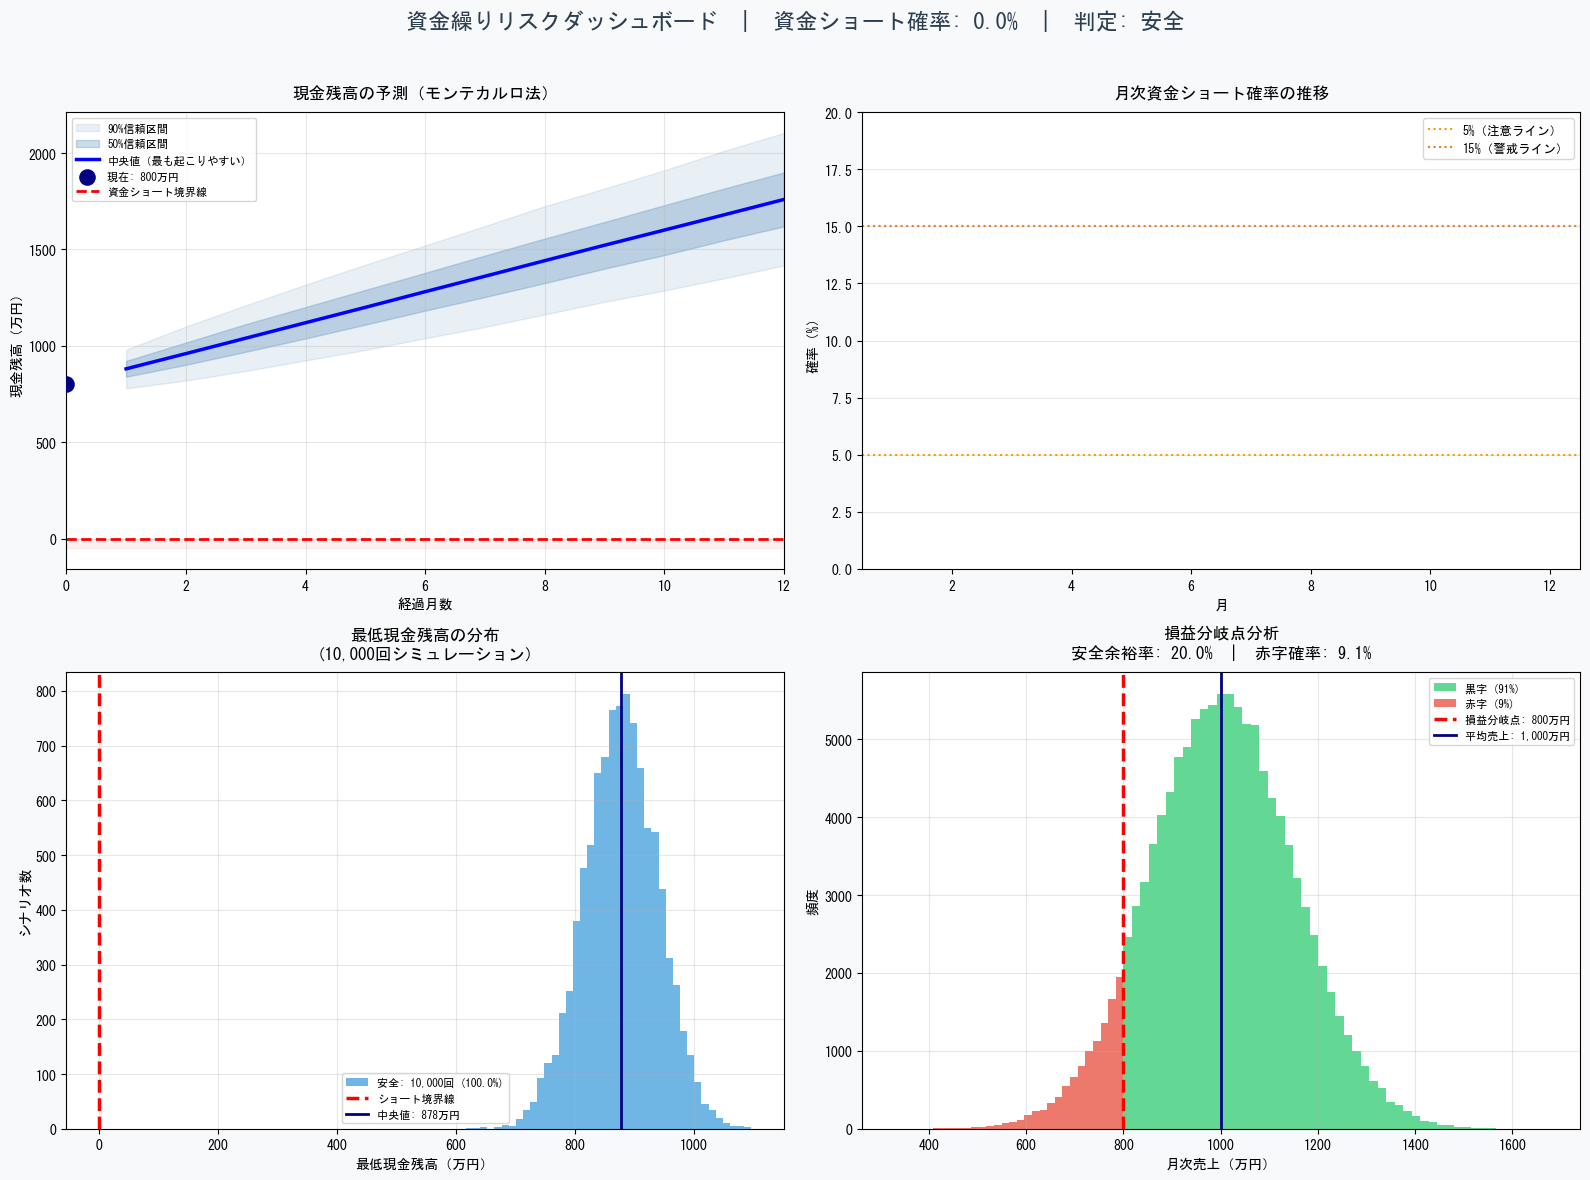

✅ メインダッシュボード保存完了: C:\Users\TSR\Desktop\CFMプログラム\資金繰りダッシュボード.png


In [6]:
# ============================================================
# セル6: メインダッシュボードの作成（完全日本語版）
# ============================================================

def create_dashboard_jp(
    cash_paths: np.ndarray,
    sales_sim: np.ndarray,
    metrics: dict,
    params: CashFlowParameters,
    save_path: Path,
) -> None:
    """
    日本語版ダッシュボードを作成して保存する。
    """
    
    T = params.simulation_months
    months = np.arange(0, T + 1)
    months_future = np.arange(1, T + 1)
    pct = metrics['cash_percentiles']
    
    fig = plt.figure(figsize=(16, 12), facecolor='#f8f9fa')
    
    # タイトル
    risk_pct = metrics['cumulative_shortfall_prob']
    status = '安全' if risk_pct < 0.05 else '注意' if risk_pct < 0.15 else '警戒' if risk_pct < 0.30 else '危険'
    fig.suptitle(
        f'資金繰りリスクダッシュボード  |  資金ショート確率: {risk_pct:.1%}  |  判定: {status}',
        fontsize=16, fontweight='bold', y=0.98, color='#2c3e50'
    )
    
    # グラフ1: 現金残高予測
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_facecolor('#ffffff')
    ax1.fill_between(months_future, pct['p5'], pct['p95'], alpha=0.12, color='steelblue', label='90%信頼区間')
    ax1.fill_between(months_future, pct['p25'], pct['p75'], alpha=0.28, color='steelblue', label='50%信頼区間')
    ax1.plot(months_future, pct['p50'], 'b-', linewidth=2.5, label='中央値（最も起こりやすい）', zorder=5)
    ax1.scatter([0], [params.cash_balance], s=120, color='navy', zorder=6, label=f'現在: {params.cash_balance:,}万円')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='資金ショート境界線')
    ymin = min(pct['p5'].min() * 1.3, -50)
    ax1.fill_between([0, T], [ymin, ymin], [0, 0], alpha=0.06, color='red')
    ax1.set_title('現金残高の予測（モンテカルロ法）', fontsize=12, fontweight='bold', pad=10)
    ax1.set_xlabel('経過月数', fontsize=10)
    ax1.set_ylabel('現金残高（万円）', fontsize=10)
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, T)
    
    # グラフ2: 月次ショート確率
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_facecolor('#ffffff')
    mp = metrics['monthly_shortfall_prob'] * 100
    bar_colors = ['#2ecc71' if p < 5 else '#f39c12' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' for p in mp]
    ax2.bar(months_future, mp, color=bar_colors, alpha=0.85, edgecolor='white')
    ax2.axhline(y=5, color='#f39c12', linestyle=':', linewidth=1.5, label='5%（注意ライン）')
    ax2.axhline(y=15, color='#e67e22', linestyle=':', linewidth=1.5, label='15%（警戒ライン）')
    ax2.set_title('月次資金ショート確率の推移', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xlabel('月', fontsize=10)
    ax2.set_ylabel('確率（%）', fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xlim(0.5, T + 0.5)
    ax2.set_ylim(0, max(mp.max() * 1.5, 20))
    
    # グラフ3: 最低残高の分布
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_facecolor('#ffffff')
    min_cash = metrics['min_cash_per_sim']
    n_neg = (min_cash < 0).sum()
    n_pos = (min_cash >= 0).sum()
    if min_cash.min() < 0:
        ax3.hist(min_cash[min_cash < 0], bins=25, color='#e74c3c', alpha=0.7, 
                label=f'ショート発生: {n_neg:,}回 ({n_neg/params.num_simulations:.1%})')
    ax3.hist(min_cash[min_cash >= 0], bins=40, color='#3498db', alpha=0.7, 
            label=f'安全: {n_pos:,}回 ({n_pos/params.num_simulations:.1%})')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='ショート境界線')
    ax3.axvline(x=np.median(min_cash), color='navy', linestyle='-', linewidth=2, 
               label=f'中央値: {np.median(min_cash):,.0f}万円')
    ax3.set_title(f'最低現金残高の分布\n（{params.num_simulations:,}回シミュレーション）', 
                 fontsize=12, fontweight='bold', pad=10)
    ax3.set_xlabel('最低現金残高（万円）', fontsize=10)
    ax3.set_ylabel('シナリオ数', fontsize=10)
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # グラフ4: 損益分岐点分析
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_facecolor('#ffffff')
    bep = metrics['breakeven_sales']
    all_sales = sales_sim.flatten()
    ax4.hist(all_sales[all_sales >= bep], bins=50, color='#2ecc71', alpha=0.75,
            label=f'黒字 ({(all_sales>=bep).mean():.0%})')
    if (all_sales < bep).any():
        ax4.hist(all_sales[all_sales < bep], bins=30, color='#e74c3c', alpha=0.75,
                label=f'赤字 ({(all_sales<bep).mean():.0%})')
    ax4.axvline(x=bep, color='red', linestyle='--', linewidth=2.5, label=f'損益分岐点: {bep:,.0f}万円')
    ax4.axvline(x=params.monthly_sales, color='navy', linestyle='-', linewidth=2, 
               label=f'平均売上: {params.monthly_sales:,.0f}万円')
    safety_margin = (params.monthly_sales - bep) / params.monthly_sales
    ax4.set_title(f'損益分岐点分析\n安全余裕率: {safety_margin:.1%}  |  赤字確率: {metrics["avg_deficit_prob"]:.1%}',
                 fontsize=12, fontweight='bold', pad=10)
    ax4.set_xlabel('月次売上（万円）', fontsize=10)
    ax4.set_ylabel('頻度', fontsize=10)
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    print(f"✅ メインダッシュボード保存完了: {save_path}")


# ダッシュボード作成
dashboard_path = OUTPUT_DIR / '資金繰りダッシュボード.png'
print("📊 ダッシュボードを作成中...")
create_dashboard_jp(cash_paths, sales_sim, metrics, params, dashboard_path)

In [7]:
# ============================================================
# セル7: 感度分析（What-if シミュレーション）
# ============================================================

def sensitivity_analysis(
    base_params: CashFlowParameters,
    scenarios: dict,
) -> list:
    """
    感度分析: 各パラメータを変化させたときの影響を比較する。
    """
    
    print("\n" + "=" * 55)
    print("【感度分析: シナリオ別リスク比較】")
    print("=" * 55)
    print(f"{'シナリオ':<25} {'ショート確率':>12} {'最終残高(中央値)':>15}")
    print("-" * 55)
    
    results = []
    
    for scenario_name, changes in scenarios.items():
        import copy
        test_params = copy.copy(base_params)
        for key, value in changes.items():
            setattr(test_params, key, value)
        
        np.random.seed(42)
        paths, s_sim, _ = run_monte_carlo_simulation(test_params)
        m = calculate_risk_metrics(paths, s_sim, test_params)
        
        prob = m['cumulative_shortfall_prob']
        final_median = np.median(paths[:, -1])
        
        icon = '🟢' if prob < 0.05 else '🟡' if prob < 0.15 else '🟠' if prob < 0.30 else '🔴'
        print(f"{scenario_name:<24} {icon} {prob:>9.1%}  {final_median:>13,.0f} 万円")
        
        results.append((scenario_name, prob, final_median))
    
    print("=" * 55)
    print("\n💡 上記の比較で最も効果的な改善策が見えてきます。")
    
    return results


# シナリオ定義
scenarios = {
    "①ベースケース（現状）": {},
    "②固定費10%削減": {"monthly_fixed_cost": params.monthly_fixed_cost * 0.9},
    "③固定費20%削減": {"monthly_fixed_cost": params.monthly_fixed_cost * 0.8},
    "④売上10%向上": {"monthly_sales": params.monthly_sales * 1.1},
    "⑤売上10%減少": {"monthly_sales": params.monthly_sales * 0.9},
    "⑥売上20%減少（ストレス）": {"monthly_sales": params.monthly_sales * 0.8},
    "⑦変動リスク拡大（30%）": {"sales_volatility": 0.30},
    "⑧現金積増（+300万）": {"cash_balance": params.cash_balance + 300},
}

sensitivity_results = sensitivity_analysis(params, scenarios)


【感度分析: シナリオ別リスク比較】
シナリオ                            ショート確率       最終残高(中央値)
-------------------------------------------------------
①ベースケース（現状）              🟢      0.0%          1,760 万円
②固定費10%削減                🟢      0.0%          2,144 万円
③固定費20%削減                🟢      0.0%          2,528 万円
④売上10%向上                 🟢      0.0%          2,240 万円
⑤売上10%減少                 🟢      0.0%          1,280 万円
⑥売上20%減少（ストレス）           🟢      0.0%            800 万円
⑦変動リスク拡大（30%）            🟢      0.0%          1,759 万円
⑧現金積増（+300万）             🟢      0.0%          2,060 万円

💡 上記の比較で最も効果的な改善策が見えてきます。


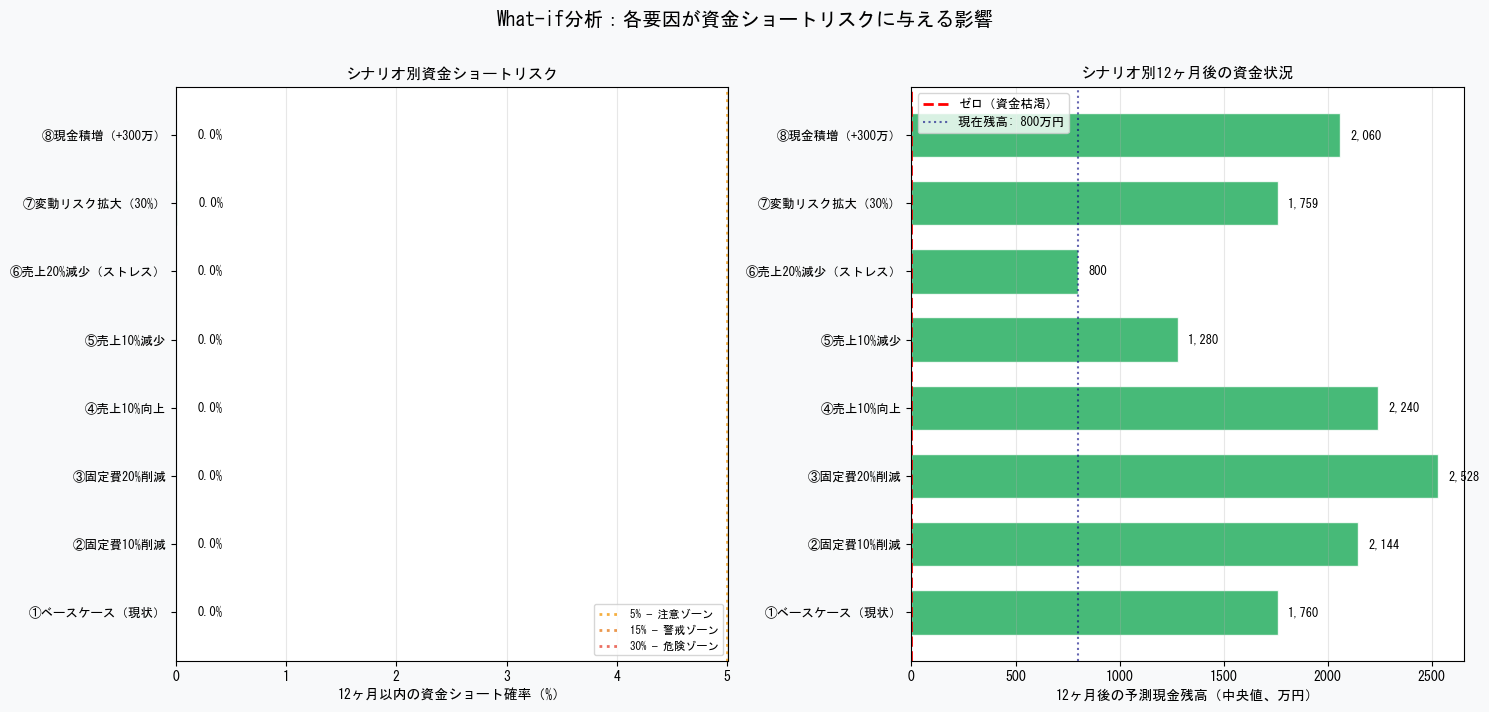

✅ 感度分析グラフ保存完了: C:\Users\TSR\Desktop\CFMプログラム\感度分析.png

✅ Phase 1 シミュレーション完了！

【作成されたファイル】
  📊 資金繰りダッシュボード.png
  📊 感度分析.png

【保存場所】
  C:\Users\TSR\Desktop\CFMプログラム

【ファイルの使い方】
  1. 上記フォルダを開いてPNGファイルを確認
  2. PowerPointやWordに貼り付けて報告資料に
  3. 右クリック→送る→メール受信者でメール送信も可能


In [8]:
# ============================================================
# セル8: 感度分析グラフの作成（完全日本語版）
# ============================================================

def plot_sensitivity_jp(results: list, params: CashFlowParameters, save_path: Path) -> None:
    """
    日本語版の感度分析グラフを作成して保存する。
    """
    
    scenario_names = [r[0] for r in results]
    probs = [r[1] * 100 for r in results]
    finals = [r[2] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), facecolor='#f8f9fa')
    fig.suptitle('What-if分析：各要因が資金ショートリスクに与える影響', 
                 fontsize=14, fontweight='bold', y=1.01)
    
    # グラフ1: ショート確率比較
    ax1.set_facecolor('#ffffff')
    bar_colors = ['#2ecc71' if p < 5 else '#f1c40f' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' for p in probs]
    bars = ax1.barh(range(len(scenario_names)), probs, color=bar_colors, alpha=0.85, edgecolor='white', height=0.65)
    
    for bar, p in zip(bars, probs):
        ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
                f'{p:.1f}%', va='center', fontsize=9, fontweight='bold')
    
    ax1.axvline(x=5, color='#f39c12', linestyle=':', linewidth=2, alpha=0.8, label='5% — 注意ゾーン')
    ax1.axvline(x=15, color='#e67e22', linestyle=':', linewidth=2, alpha=0.8, label='15% — 警戒ゾーン')
    ax1.axvline(x=30, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.8, label='30% — 危険ゾーン')
    ax1.set_yticks(range(len(scenario_names)))
    ax1.set_yticklabels(scenario_names, fontsize=9)
    ax1.set_xlabel('12ヶ月以内の資金ショート確率（%）', fontsize=10)
    ax1.set_title('シナリオ別資金ショートリスク', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8, loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, max(probs) * 1.3 + 5)
    
    # グラフ2: 最終残高比較
    ax2.set_facecolor('#ffffff')
    bar_colors2 = ['#27ae60' if f >= 500 else '#2ecc71' if f >= 0 else '#e74c3c' for f in finals]
    bars2 = ax2.barh(range(len(scenario_names)), finals, color=bar_colors2, alpha=0.85, edgecolor='white', height=0.65)
    
    for bar, f in zip(bars2, finals):
        xpos = bar.get_width() + (max(finals)*0.02)
        ax2.text(xpos, bar.get_y() + bar.get_height()/2,
                f'{f:,.0f}', va='center', fontsize=9, fontweight='bold')
    
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='ゼロ（資金枯渇）')
    ax2.axvline(x=params.cash_balance, color='navy', linestyle=':', linewidth=1.5, alpha=0.6,
               label=f'現在残高: {params.cash_balance:,}万円')
    ax2.set_yticks(range(len(scenario_names)))
    ax2.set_yticklabels(scenario_names, fontsize=9)
    ax2.set_xlabel(f'12ヶ月後の予測現金残高（中央値、万円）', fontsize=10)
    ax2.set_title('シナリオ別12ヶ月後の資金状況', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    print(f"✅ 感度分析グラフ保存完了: {save_path}")


# 感度分析グラフ作成
sensitivity_path = OUTPUT_DIR / '感度分析.png'
plot_sensitivity_jp(sensitivity_results, params, sensitivity_path)

print()
print("=" * 55)
print("✅ Phase 1 シミュレーション完了！")
print()
print("【作成されたファイル】")
print(f"  📊 {dashboard_path.name}")
print(f"  📊 {sensitivity_path.name}")
print()
print(f"【保存場所】")
print(f"  {OUTPUT_DIR}")
print()
print("【ファイルの使い方】")
print("  1. 上記フォルダを開いてPNGファイルを確認")
print("  2. PowerPointやWordに貼り付けて報告資料に")
print("  3. 右クリック→送る→メール受信者でメール送信も可能")
print("=" * 55)

---

## 📝 使い方ガイド

### パラメータの変更方法

セル3の数字を自社の実態に合わせて変更してください。

```python
# 例: 飲食店（月次売上800万、現金残高300万、固定費500万）
params = CashFlowParameters(
    monthly_sales=800,
    cash_balance=300,
    monthly_fixed_cost=500,
    cost_rate=0.65,          # 飲食は原価率高め
    sales_volatility=0.20,   # 季節変動あり
    accounts_receivable_days=0,  # 現金商売
)
```

変更後、もう一度「Kernel」→「Restart & Run All」で実行してください。

### 保存されたグラフの確認方法

1. **Jupyterのファイル一覧に戻る**: 左上のJupyterロゴをクリック
2. **PNGファイルを探す**: 同じフォルダ内に作成されています
   - `資金繰りダッシュボード.png`
   - `感度分析.png`
3. **Windowsエクスプローラーで開く**: ファイル一覧の右上「表示」→「フォルダを開く」

### よくある質問

**Q: グラフの文字が小さくて見づらい**  
A: PNGファイルを開いて拡大表示してください。高解像度（150dpi）で保存されています。

**Q: グラフをメールで送りたい**  
A: PNGファイルを右クリック→「送る」→「メール受信者」で添付できます。

**Q: PowerPointに貼り付けたい**  
A: PNGファイルをドラッグ&ドロップするだけでOKです。

---

**次のステップ：Phase 2（ストレステスト）の開発**

- 取引先倒産シミュレーション
- 金利上昇の影響分析
- 売上急落時の資金繰り

---

*このツールは転職・副業ポートフォリオとして開発中です*

In [ ]:
"""
Phase 2: ストレステスト機能

売上急落シナリオを追加し、突発的なショックへの耐性を評価します。
"""

from dataclasses import dataclass
from typing import Dict, List, Optional

@dataclass
class StressScenario:
    """
    ストレステストのシナリオを定義するクラス。
    
    Parameters
    ----------
    name : str
        シナリオ名（日本語）
    start_month : int
        ストレスが始まる月（1から開始）
    sales_reduction_rate : float
        売上減少率（0〜1の小数）。例: 30%減少なら0.30
    duration_months : int
        ストレスが継続する期間（月数）。Noneの場合は最後まで継続
    
    Examples
    --------
    # コロナショックを想定（即時50%減、12ヶ月継続）
    scenario = StressScenario(
        name="コロナショック（売上50%減）",
        start_month=1,
        sales_reduction_rate=0.50,
        duration_months=12
    )
    """
    
    name: str
    start_month: int
    sales_reduction_rate: float
    duration_months: Optional[int] = None
    
    def validate(self, simulation_months: int) -> None:
        """入力値の妥当性チェック"""
        if not 1 <= self.start_month <= simulation_months:
            raise ValueError(f"開始月は1〜{simulation_months}の範囲で指定してください。入力値: {self.start_month}")
        if not 0 <= self.sales_reduction_rate <= 1:
            raise ValueError(f"売上減少率は0〜1の範囲で指定してください。入力値: {self.sales_reduction_rate}")
        if self.duration_months is not None:
            if self.duration_months < 1:
                raise ValueError(f"継続期間は1ヶ月以上を指定してください。入力値: {self.duration_months}")


# 事前定義されたストレスシナリオ
PREDEFINED_SCENARIOS = {
    "軽度の売上減少": StressScenario(
        name="軽度の売上減少（20%減・3ヶ月目から）",
        start_month=3,
        sales_reduction_rate=0.20,
        duration_months=None
    ),
    "中度の売上減少": StressScenario(
        name="中度の売上減少（30%減・3ヶ月目から）",
        start_month=3,
        sales_reduction_rate=0.30,
        duration_months=None
    ),
    "重度の売上減少": StressScenario(
        name="重度の売上減少（50%減・即時）",
        start_month=1,
        sales_reduction_rate=0.50,
        duration_months=None
    ),
    "一時的ショック": StressScenario(
        name="一時的ショック（40%減・3ヶ月間）",
        start_month=3,
        sales_reduction_rate=0.40,
        duration_months=3
    )
}

print("✅ ストレステストパラメータの定義完了")


In [ ]:
def run_stress_test(
    base_params: CashFlowParameters,
    stress_scenario: StressScenario,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    ストレステストを実行する。
    
    Phase 1のモンテカルロシミュレーションに、売上急落ストレスを適用します。
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ（Phase 1と同じ）
    stress_scenario : StressScenario
        適用するストレスシナリオ
    
    Returns
    -------
    cash_paths : np.ndarray
        現金残高の推移（形状: [シミュレーション数, 月数+1]）
    monthly_sales_sim : np.ndarray
        月次売上シミュレーション（ストレス適用済み）
    monthly_cf_sim : np.ndarray
        月次キャッシュフロー
    """
    
    # 入力値チェック
    stress_scenario.validate(base_params.simulation_months)
    
    n = base_params.num_simulations
    T = base_params.simulation_months
    
    # 売上のシミュレーション（Phase 1と同じ）
    monthly_sales_sim = np.random.normal(
        loc=base_params.monthly_sales,
        scale=base_params.monthly_sales * base_params.sales_volatility,
        size=(n, T)
    )
    monthly_sales_sim = np.maximum(monthly_sales_sim, 0)
    
    # ストレスを適用
    start_idx = stress_scenario.start_month - 1  # 0-indexed
    
    if stress_scenario.duration_months is None:
        # 開始月から最後まで継続
        end_idx = T
    else:
        # 指定期間のみ
        end_idx = min(start_idx + stress_scenario.duration_months, T)
    
    # 売上減少を適用
    reduction_factor = 1.0 - stress_scenario.sales_reduction_rate
    monthly_sales_sim[:, start_idx:end_idx] *= reduction_factor
    
    # キャッシュフローの計算（Phase 1と同じロジック）
    cash_inflow = monthly_sales_sim * base_params.gross_profit_rate()
    monthly_cf_sim = cash_inflow - base_params.monthly_fixed_cost
    
    # 現金残高の推移
    cash_paths = np.zeros((n, T + 1))
    cash_paths[:, 0] = base_params.cash_balance
    for t in range(T):
        cash_paths[:, t + 1] = cash_paths[:, t] + monthly_cf_sim[:, t]
    
    return cash_paths, monthly_sales_sim, monthly_cf_sim


def compare_stress_scenarios(
    base_params: CashFlowParameters,
    scenarios: Dict[str, StressScenario],
) -> List[tuple]:
    """
    複数のストレスシナリオを比較する。
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    scenarios : Dict[str, StressScenario]
        比較するシナリオの辞書（キー: 表示名、値: シナリオ）
    
    Returns
    -------
    results : List[tuple]
        各シナリオの結果リスト。各要素は (シナリオ名, ショート確率, 最終残高中央値)
    """
    
    print()
    print("=" * 60)
    print("【ストレステスト: シナリオ比較実行中】")
    print("=" * 60)
    
    results = []
    
    for key, scenario in scenarios.items():
        print(f"⏳ {scenario.name} を実行中...")
        
        # シミュレーション実行
        np.random.seed(42)  # 再現性確保
        cash_paths, sales_sim, cf_sim = run_stress_test(base_params, scenario)
        
        # リスク指標計算
        metrics = calculate_risk_metrics(cash_paths, sales_sim, base_params)
        
        shortfall_prob = metrics['cumulative_shortfall_prob']
        final_cash_median = np.median(cash_paths[:, -1])
        
        # リスク判定
        if shortfall_prob < 0.05:
            status = "🟢 安全"
        elif shortfall_prob < 0.15:
            status = "🟡 注意"
        elif shortfall_prob < 0.30:
            status = "🟠 警戒"
        else:
            status = "🔴 危険"
        
        print(f"   → ショート確率: {shortfall_prob:.1%} {status}")
        print(f"   → 12ヶ月後残高（中央値）: {final_cash_median:,.0f}万円")
        print()
        
        results.append((scenario.name, shortfall_prob, final_cash_median))
    
    print("=" * 60)
    print("✅ すべてのシナリオ実行完了")
    print("=" * 60)
    
    return results

print("✅ ストレステスト実行関数の定義完了")


In [ ]:
def create_stress_test_dashboard(
    results: List[tuple],
    base_params: CashFlowParameters,
    save_path: Path,
) -> None:
    """
    ストレステスト結果のダッシュボードを作成する。
    
    Parameters
    ----------
    results : List[tuple]
        シナリオ比較結果（compare_stress_scenariosの出力）
    base_params : CashFlowParameters
        基本パラメータ
    save_path : Path
        保存先パス
    """
    
    scenario_names = [r[0] for r in results]
    shortfall_probs = [r[1] * 100 for r in results]
    final_cash = [r[2] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), facecolor='#f8f9fa')
    
    fig.suptitle(
        'ストレステスト結果：売上急落シナリオでの資金繰りリスク評価',
        fontsize=16, fontweight='bold', y=0.98, color='#2c3e50'
    )
    
    # グラフ1: ショート確率比較
    ax1.set_facecolor('#ffffff')
    bar_colors = ['#2ecc71' if p < 5 else '#f1c40f' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' 
                  for p in shortfall_probs]
    
    bars1 = ax1.barh(range(len(scenario_names)), shortfall_probs, 
                     color=bar_colors, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, prob in zip(bars1, shortfall_probs):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{prob:.1f}%', va='center', fontsize=10, fontweight='bold')
    
    # 基準線
    ax1.axvline(x=5, color='#f39c12', linestyle=':', linewidth=2, alpha=0.7, label='5% 注意レベル')
    ax1.axvline(x=15, color='#e67e22', linestyle=':', linewidth=2, alpha=0.7, label='15% 警戒レベル')
    ax1.axvline(x=30, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.7, label='30% 危険レベル')
    
    ax1.set_yticks(range(len(scenario_names)))
    ax1.set_yticklabels(scenario_names, fontsize=10)
    ax1.set_xlabel('12ヶ月以内の資金ショート確率（%）', fontsize=11, fontweight='bold')
    ax1.set_title('シナリオ別 資金ショートリスク', fontsize=12, fontweight='bold', pad=15)
    ax1.legend(fontsize=9, loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, max(shortfall_probs) * 1.2 + 5)
    
    # グラフ2: 最終残高比較
    ax2.set_facecolor('#ffffff')
    bar_colors2 = ['#27ae60' if f >= 500 else '#2ecc71' if f >= 0 else '#e74c3c' 
                   for f in final_cash]
    
    bars2 = ax2.barh(range(len(scenario_names)), final_cash,
                     color=bar_colors2, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, cash in zip(bars2, final_cash):
        xpos = bar.get_width() + (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        if cash < 0:
            xpos = cash - (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        ax2.text(xpos, bar.get_y() + bar.get_height()/2,
                f'{cash:,.0f}', va='center', ha='left' if cash >= 0 else 'right',
                fontsize=10, fontweight='bold')
    
    # 基準線
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='ゼロ（資金枯渇）')
    ax2.axvline(x=base_params.cash_balance, color='navy', linestyle=':', linewidth=1.5, alpha=0.6,
               label=f'現在残高: {base_params.cash_balance:,}万円')
    
    ax2.set_yticks(range(len(scenario_names)))
    ax2.set_yticklabels(scenario_names, fontsize=10)
    ax2.set_xlabel('12ヶ月後の予測現金残高（中央値、万円）', fontsize=11, fontweight='bold')
    ax2.set_title('シナリオ別 12ヶ月後の資金状況', fontsize=12, fontweight='bold', pad=15)
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    
    print(f"✅ ストレステストダッシュボード保存完了: {save_path}")

print("✅ 可視化関数の定義完了")


In [ ]:
print()
print("=" * 60)
print("Phase 2: ストレステスト実行")
print("=" * 60)
print()
print("Phase 1の基本パラメータを使用して、")
print("4つの売上急落シナリオでストレステストを実行します。")
print()

# Phase 1のparamsを使用（すでに定義済みのはず）
# シナリオ辞書を作成
stress_scenarios = PREDEFINED_SCENARIOS

# ストレステスト実行
stress_results = compare_stress_scenarios(params, stress_scenarios)

# 結果表示
print()
print("=" * 60)
print("【ストレステスト結果サマリー】")
print("=" * 60)
print(f"{'シナリオ名':<35} {'ショート確率':>12} {'最終残高':>15}")
print("-" * 60)

for name, prob, final in stress_results:
    # リスクアイコン
    if prob < 0.05:
        icon = "🟢"
    elif prob < 0.15:
        icon = "🟡"
    elif prob < 0.30:
        icon = "🟠"
    else:
        icon = "🔴"
    
    print(f"{name:<35} {icon} {prob:>10.1%}  {final:>13,.0f}万円")

print("=" * 60)

# ダッシュボード作成
stress_dashboard_path = OUTPUT_DIR / 'ストレステスト結果.png'
print()
print("📊 ストレステストダッシュボードを作成中...")
create_stress_test_dashboard(stress_results, params, stress_dashboard_path)

print()
print("=" * 60)
print("✅ Phase 2 ストレステスト完了！")
print()
print("【作成されたファイル】")
print(f"  📊 {stress_dashboard_path.name}")
print()
print(f"【保存場所】")
print(f"  {OUTPUT_DIR}")
print("=" * 60)


In [ ]:
"""
Phase 2-2: 取引先倒産シミュレーション

大口取引先の倒産により、売掛金回収不能と売上減少が同時に発生する
ケースをシミュレーションします。
"""

from dataclasses import dataclass
from typing import Optional

@dataclass
class CustomerBankruptcyScenario:
    """
    取引先倒産シナリオを定義するクラス。
    
    取引先倒産により以下の2つの影響が発生：
    1. 売掛金の回収不能（一時的な大きな損失）
    2. 継続的な売上減少（取引先喪失による）
    
    Parameters
    ----------
    name : str
        シナリオ名（日本語）
    bankruptcy_month : int
        倒産発生月（1から開始）
    receivable_amount : float
        回収不能となる売掛金額（万円）
    monthly_sales_share : float
        倒産した取引先の月次売上シェア（0〜1の小数）
        例: 20%なら0.20。倒産後はこの分の売上が失われる
    
    Examples
    --------
    # 大口取引先（売上の30%）が6ヶ月目に倒産
    # 売掛金300万円が回収不能
    scenario = CustomerBankruptcyScenario(
        name="大口取引先倒産（売上30%・売掛金300万円）",
        bankruptcy_month=6,
        receivable_amount=300,
        monthly_sales_share=0.30
    )
    """
    
    name: str
    bankruptcy_month: int
    receivable_amount: float
    monthly_sales_share: float
    
    def validate(self, simulation_months: int, monthly_sales: float) -> None:
        """入力値の妥当性チェック"""
        if not 1 <= self.bankruptcy_month <= simulation_months:
            raise ValueError(
                f"倒産発生月は1〜{simulation_months}の範囲で指定してください。"
                f"入力値: {self.bankruptcy_month}"
            )
        
        if self.receivable_amount < 0:
            raise ValueError(
                f"売掛金額は0以上を指定してください。入力値: {self.receivable_amount}"
            )
        
        if not 0 <= self.monthly_sales_share <= 1:
            raise ValueError(
                f"売上シェアは0〜1の範囲で指定してください。入力値: {self.monthly_sales_share}"
            )
        
        # 警告: 売掛金が売上の3ヶ月分を超える場合
        if self.receivable_amount > monthly_sales * 3:
            print(f"⚠️  警告: 売掛金額が月次売上の3ヶ月分を超えています。")
            print(f"   売掛金: {self.receivable_amount}万円 vs 月次売上: {monthly_sales}万円")


# 事前定義された倒産シナリオ
BANKRUPTCY_SCENARIOS = {
    "小規模取引先": CustomerBankruptcyScenario(
        name="小規模取引先倒産（売上10%・売掛金100万円）",
        bankruptcy_month=6,
        receivable_amount=100,
        monthly_sales_share=0.10
    ),
    "中規模取引先": CustomerBankruptcyScenario(
        name="中規模取引先倒産（売上20%・売掛金300万円）",
        bankruptcy_month=6,
        receivable_amount=300,
        monthly_sales_share=0.20
    ),
    "大口取引先": CustomerBankruptcyScenario(
        name="大口取引先倒産（売上30%・売掛金500万円）",
        bankruptcy_month=6,
        receivable_amount=500,
        monthly_sales_share=0.30
    ),
    "最大手取引先": CustomerBankruptcyScenario(
        name="最大手取引先倒産（売上40%・売掛金800万円）",
        bankruptcy_month=6,
        receivable_amount=800,
        monthly_sales_share=0.40
    )
}

print("✅ 取引先倒産シナリオの定義完了")


In [ ]:
def run_bankruptcy_simulation(
    base_params: CashFlowParameters,
    bankruptcy_scenario: CustomerBankruptcyScenario,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    取引先倒産シミュレーションを実行する。
    
    倒産により以下の2つの影響をシミュレート：
    1. 倒産月に売掛金が回収不能（一時的な大損失）
    2. 倒産月以降、継続的に売上が減少（取引先喪失）
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    bankruptcy_scenario : CustomerBankruptcyScenario
        倒産シナリオ
    
    Returns
    -------
    cash_paths : np.ndarray
        現金残高の推移（形状: [シミュレーション数, 月数+1]）
    monthly_sales_sim : np.ndarray
        月次売上シミュレーション（倒産影響込み）
    monthly_cf_sim : np.ndarray
        月次キャッシュフロー
    """
    
    # 入力値チェック
    bankruptcy_scenario.validate(base_params.simulation_months, base_params.monthly_sales)
    
    n = base_params.num_simulations
    T = base_params.simulation_months
    
    # 売上のシミュレーション（基本）
    monthly_sales_sim = np.random.normal(
        loc=base_params.monthly_sales,
        scale=base_params.monthly_sales * base_params.sales_volatility,
        size=(n, T)
    )
    monthly_sales_sim = np.maximum(monthly_sales_sim, 0)
    
    # 倒産による売上減少を適用（倒産月以降）
    bankruptcy_idx = bankruptcy_scenario.bankruptcy_month - 1
    reduction_factor = 1.0 - bankruptcy_scenario.monthly_sales_share
    monthly_sales_sim[:, bankruptcy_idx:] *= reduction_factor
    
    # キャッシュフローの計算
    cash_inflow = monthly_sales_sim * base_params.gross_profit_rate()
    monthly_cf_sim = cash_inflow - base_params.monthly_fixed_cost
    
    # 現金残高の推移
    cash_paths = np.zeros((n, T + 1))
    cash_paths[:, 0] = base_params.cash_balance
    
    for t in range(T):
        # 通常のキャッシュフロー
        cash_paths[:, t + 1] = cash_paths[:, t] + monthly_cf_sim[:, t]
        
        # 倒産月に売掛金回収不能の損失を適用
        if t == bankruptcy_idx:
            cash_paths[:, t + 1] -= bankruptcy_scenario.receivable_amount
    
    return cash_paths, monthly_sales_sim, monthly_cf_sim


def compare_bankruptcy_scenarios(
    base_params: CashFlowParameters,
    scenarios: Dict[str, CustomerBankruptcyScenario],
) -> List[tuple]:
    """
    複数の取引先倒産シナリオを比較する。
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    scenarios : Dict[str, CustomerBankruptcyScenario]
        比較するシナリオの辞書
    
    Returns
    -------
    results : List[tuple]
        各シナリオの結果リスト。各要素は (シナリオ名, ショート確率, 最終残高中央値)
    """
    
    print()
    print("=" * 60)
    print("【取引先倒産シミュレーション: 実行中】")
    print("=" * 60)
    
    results = []
    
    for key, scenario in scenarios.items():
        print(f"⏳ {scenario.name} を実行中...")
        
        # シミュレーション実行
        np.random.seed(42)
        cash_paths, sales_sim, cf_sim = run_bankruptcy_simulation(base_params, scenario)
        
        # リスク指標計算
        metrics = calculate_risk_metrics(cash_paths, sales_sim, base_params)
        
        shortfall_prob = metrics['cumulative_shortfall_prob']
        final_cash_median = np.median(cash_paths[:, -1])
        
        # リスク判定
        if shortfall_prob < 0.05:
            status = "🟢 安全"
        elif shortfall_prob < 0.15:
            status = "🟡 注意"
        elif shortfall_prob < 0.30:
            status = "🟠 警戒"
        else:
            status = "🔴 危険"
        
        print(f"   → ショート確率: {shortfall_prob:.1%} {status}")
        print(f"   → 12ヶ月後残高（中央値）: {final_cash_median:,.0f}万円")
        print(f"   → 売掛金損失: {scenario.receivable_amount:,.0f}万円")
        print(f"   → 継続的売上減少: {scenario.monthly_sales_share:.0%}")
        print()
        
        results.append((scenario.name, shortfall_prob, final_cash_median))
    
    print("=" * 60)
    print("✅ すべてのシナリオ実行完了")
    print("=" * 60)
    
    return results

print("✅ 取引先倒産シミュレーション関数の定義完了")


In [ ]:
def create_bankruptcy_dashboard(
    results: List[tuple],
    base_params: CashFlowParameters,
    save_path: Path,
) -> None:
    """
    取引先倒産シミュレーション結果のダッシュボードを作成する。
    
    Parameters
    ----------
    results : List[tuple]
        シナリオ比較結果
    base_params : CashFlowParameters
        基本パラメータ
    save_path : Path
        保存先パス
    """
    
    scenario_names = [r[0] for r in results]
    shortfall_probs = [r[1] * 100 for r in results]
    final_cash = [r[2] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), facecolor='#f8f9fa')
    
    fig.suptitle(
        '取引先倒産シミュレーション：大口取引先倒産時の資金繰りリスク',
        fontsize=16, fontweight='bold', y=0.98, color='#2c3e50'
    )
    
    # グラフ1: ショート確率比較
    ax1.set_facecolor('#ffffff')
    bar_colors = ['#2ecc71' if p < 5 else '#f1c40f' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' 
                  for p in shortfall_probs]
    
    bars1 = ax1.barh(range(len(scenario_names)), shortfall_probs, 
                     color=bar_colors, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, prob in zip(bars1, shortfall_probs):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{prob:.1f}%', va='center', fontsize=11, fontweight='bold')
    
    # 基準線
    ax1.axvline(x=5, color='#f39c12', linestyle=':', linewidth=2, alpha=0.7, label='5% 注意レベル')
    ax1.axvline(x=15, color='#e67e22', linestyle=':', linewidth=2, alpha=0.7, label='15% 警戒レベル')
    ax1.axvline(x=30, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.7, label='30% 危険レベル')
    
    ax1.set_yticks(range(len(scenario_names)))
    ax1.set_yticklabels(scenario_names, fontsize=10)
    ax1.set_xlabel('12ヶ月以内の資金ショート確率（%）', fontsize=11, fontweight='bold')
    ax1.set_title('取引先規模別 資金ショートリスク', fontsize=12, fontweight='bold', pad=15)
    ax1.legend(fontsize=9, loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, max(shortfall_probs) * 1.2 + 5)
    
    # グラフ2: 最終残高比較
    ax2.set_facecolor('#ffffff')
    bar_colors2 = ['#27ae60' if f >= 500 else '#2ecc71' if f >= 0 else '#e74c3c' 
                   for f in final_cash]
    
    bars2 = ax2.barh(range(len(scenario_names)), final_cash,
                     color=bar_colors2, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, cash in zip(bars2, final_cash):
        xpos = bar.get_width() + (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        if cash < 0:
            xpos = cash - (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        ax2.text(xpos, bar.get_y() + bar.get_height()/2,
                f'{cash:,.0f}', va='center', ha='left' if cash >= 0 else 'right',
                fontsize=11, fontweight='bold')
    
    # 基準線
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='ゼロ（資金枯渇）')
    ax2.axvline(x=base_params.cash_balance, color='navy', linestyle=':', linewidth=1.5, alpha=0.6,
               label=f'現在残高: {base_params.cash_balance:,}万円')
    
    ax2.set_yticks(range(len(scenario_names)))
    ax2.set_yticklabels(scenario_names, fontsize=10)
    ax2.set_xlabel('12ヶ月後の予測現金残高（中央値、万円）', fontsize=11, fontweight='bold')
    ax2.set_title('取引先規模別 12ヶ月後の資金状況', fontsize=12, fontweight='bold', pad=15)
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    
    print(f"✅ 取引先倒産ダッシュボード保存完了: {save_path}")

print("✅ 取引先倒産可視化関数の定義完了")


In [ ]:
print()
print("=" * 60)
print("Phase 2-2: 取引先倒産シミュレーション実行")
print("=" * 60)
print()
print("4つの取引先規模（小規模〜最大手）で倒産シナリオを実行します。")
print()

# Phase 1のparamsを使用
bankruptcy_scenarios = BANKRUPTCY_SCENARIOS

# 倒産シミュレーション実行
bankruptcy_results = compare_bankruptcy_scenarios(params, bankruptcy_scenarios)

# 結果表示
print()
print("=" * 60)
print("【取引先倒産シミュレーション結果サマリー】")
print("=" * 60)
print(f"{'シナリオ名':<40} {'ショート確率':>12} {'最終残高':>15}")
print("-" * 60)

for name, prob, final in bankruptcy_results:
    # リスクアイコン
    if prob < 0.05:
        icon = "🟢"
    elif prob < 0.15:
        icon = "🟡"
    elif prob < 0.30:
        icon = "🟠"
    else:
        icon = "🔴"
    
    print(f"{name:<40} {icon} {prob:>10.1%}  {final:>13,.0f}万円")

print("=" * 60)

# ダッシュボード作成
bankruptcy_dashboard_path = OUTPUT_DIR / '取引先倒産リスク.png'
print()
print("📊 取引先倒産ダッシュボードを作成中...")
create_bankruptcy_dashboard(bankruptcy_results, params, bankruptcy_dashboard_path)

print()
print("=" * 60)
print("✅ Phase 2-2 取引先倒産シミュレーション完了！")
print()
print("【作成されたファイル】")
print(f"  📊 {bankruptcy_dashboard_path.name}")
print()
print(f"【保存場所】")
print(f"  {OUTPUT_DIR}")
print("=" * 60)


In [ ]:
"""
Phase 2-3: 金利上昇の影響分析

借入金金利の上昇により、月次利払いが増加するケースをシミュレーションします。
実質的に固定費が増加するのと同じ効果を持ちます。
"""

from dataclasses import dataclass

@dataclass
class InterestRateRiseScenario:
    """
    金利上昇シナリオを定義するクラス。
    
    借入金の金利が上昇することで、月次の利払い（固定費）が増加します。
    
    Parameters
    ----------
    name : str
        シナリオ名（日本語）
    loan_balance : float
        借入金残高（万円）
    current_rate : float
        現在の年利（0〜1の小数）。例: 1.0%なら0.01
    new_rate : float
        上昇後の年利（0〜1の小数）。例: 2.0%なら0.02
    rise_month : int
        金利上昇が発生する月（1から開始）
    
    Examples
    --------
    # 借入金3,000万円、金利が1.0%から2.0%に上昇（3ヶ月目）
    scenario = InterestRateRiseScenario(
        name="金利1%上昇（1.0%→2.0%）",
        loan_balance=3000,
        current_rate=0.01,
        new_rate=0.02,
        rise_month=3
    )
    
    # 月次利払いの増加額
    # = 3,000万円 × (0.02 - 0.01) / 12 = 2.5万円/月
    """
    
    name: str
    loan_balance: float
    current_rate: float
    new_rate: float
    rise_month: int
    
    def monthly_interest_increase(self) -> float:
        """月次利払いの増加額を計算"""
        return self.loan_balance * (self.new_rate - self.current_rate) / 12
    
    def validate(self, simulation_months: int) -> None:
        """入力値の妥当性チェック"""
        if self.loan_balance < 0:
            raise ValueError(f"借入金残高は0以上を指定してください。入力値: {self.loan_balance}")
        
        if not 0 <= self.current_rate <= 0.20:
            raise ValueError(
                f"現在金利は0〜20%の範囲で指定してください。"
                f"入力値: {self.current_rate:.1%}"
            )
        
        if not 0 <= self.new_rate <= 0.20:
            raise ValueError(
                f"上昇後金利は0〜20%の範囲で指定してください。"
                f"入力値: {self.new_rate:.1%}"
            )
        
        if self.new_rate <= self.current_rate:
            raise ValueError(
                f"上昇後金利は現在金利より高く設定してください。"
                f"現在: {self.current_rate:.1%}、上昇後: {self.new_rate:.1%}"
            )
        
        if not 1 <= self.rise_month <= simulation_months:
            raise ValueError(
                f"金利上昇月は1〜{simulation_months}の範囲で指定してください。"
                f"入力値: {self.rise_month}"
            )


# 事前定義された金利上昇シナリオ
# 前提: 借入金3,000万円、現在金利1.0%
INTEREST_RATE_SCENARIOS = {
    "軽微な上昇": InterestRateRiseScenario(
        name="金利0.5%上昇（1.0%→1.5%）借入3,000万円",
        loan_balance=3000,
        current_rate=0.010,
        new_rate=0.015,
        rise_month=3
    ),
    "中程度の上昇": InterestRateRiseScenario(
        name="金利1.0%上昇（1.0%→2.0%）借入3,000万円",
        loan_balance=3000,
        current_rate=0.010,
        new_rate=0.020,
        rise_month=3
    ),
    "大幅な上昇": InterestRateRiseScenario(
        name="金利2.0%上昇（1.0%→3.0%）借入3,000万円",
        loan_balance=3000,
        current_rate=0.010,
        new_rate=0.030,
        rise_month=3
    ),
    "急激な上昇": InterestRateRiseScenario(
        name="金利3.0%上昇（1.0%→4.0%）借入3,000万円",
        loan_balance=3000,
        current_rate=0.010,
        new_rate=0.040,
        rise_month=3
    )
}

print("✅ 金利上昇シナリオの定義完了")


In [ ]:
def run_interest_rate_simulation(
    base_params: CashFlowParameters,
    interest_scenario: InterestRateRiseScenario,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    金利上昇シミュレーションを実行する。
    
    金利上昇により月次の利払いが増加 → 固定費増加と同じ効果
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    interest_scenario : InterestRateRiseScenario
        金利上昇シナリオ
    
    Returns
    -------
    cash_paths : np.ndarray
        現金残高の推移
    monthly_sales_sim : np.ndarray
        月次売上シミュレーション
    monthly_cf_sim : np.ndarray
        月次キャッシュフロー
    """
    
    # 入力値チェック
    interest_scenario.validate(base_params.simulation_months)
    
    n = base_params.num_simulations
    T = base_params.simulation_months
    
    # 売上のシミュレーション（通常通り）
    monthly_sales_sim = np.random.normal(
        loc=base_params.monthly_sales,
        scale=base_params.monthly_sales * base_params.sales_volatility,
        size=(n, T)
    )
    monthly_sales_sim = np.maximum(monthly_sales_sim, 0)
    
    # キャッシュフローの計算
    cash_inflow = monthly_sales_sim * base_params.gross_profit_rate()
    
    # 固定費の設定（金利上昇を反映）
    rise_idx = interest_scenario.rise_month - 1
    interest_increase = interest_scenario.monthly_interest_increase()
    
    # 月ごとの固定費を配列で作成（float型で作成）
    monthly_fixed_costs = np.full(T, base_params.monthly_fixed_cost, dtype=float)
    monthly_fixed_costs[rise_idx:] += interest_increase
    
    # 月次キャッシュフロー
    monthly_cf_sim = cash_inflow - monthly_fixed_costs
    
    # 現金残高の推移
    cash_paths = np.zeros((n, T + 1))
    cash_paths[:, 0] = base_params.cash_balance
    for t in range(T):
        cash_paths[:, t + 1] = cash_paths[:, t] + monthly_cf_sim[:, t]
    
    return cash_paths, monthly_sales_sim, monthly_cf_sim


def compare_interest_rate_scenarios(
    base_params: CashFlowParameters,
    scenarios: Dict[str, InterestRateRiseScenario],
) -> List[tuple]:
    """
    複数の金利上昇シナリオを比較する。
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    scenarios : Dict[str, InterestRateRiseScenario]
        比較するシナリオの辞書
    
    Returns
    -------
    results : List[tuple]
        各シナリオの結果リスト
    """
    
    print()
    print("=" * 60)
    print("【金利上昇シミュレーション: 実行中】")
    print("=" * 60)
    
    results = []
    
    for key, scenario in scenarios.items():
        print(f"⏳ {scenario.name} を実行中...")
        
        # シミュレーション実行
        np.random.seed(42)
        cash_paths, sales_sim, cf_sim = run_interest_rate_simulation(base_params, scenario)
        
        # リスク指標計算
        metrics = calculate_risk_metrics(cash_paths, sales_sim, base_params)
        
        shortfall_prob = metrics['cumulative_shortfall_prob']
        final_cash_median = np.median(cash_paths[:, -1])
        
        # 月次利払い増加額
        interest_increase = scenario.monthly_interest_increase()
        
        # リスク判定
        if shortfall_prob < 0.05:
            status = "🟢 安全"
        elif shortfall_prob < 0.15:
            status = "🟡 注意"
        elif shortfall_prob < 0.30:
            status = "🟠 警戒"
        else:
            status = "🔴 危険"
        
        print(f"   → ショート確率: {shortfall_prob:.1%} {status}")
        print(f"   → 12ヶ月後残高（中央値）: {final_cash_median:,.0f}万円")
        print(f"   → 月次利払い増加: {interest_increase:,.1f}万円/月")
        print(f"   → 年間負担増加: {interest_increase * 12:,.0f}万円")
        print()
        
        results.append((scenario.name, shortfall_prob, final_cash_median))
    
    print("=" * 60)
    print("✅ すべてのシナリオ実行完了")
    print("=" * 60)
    
    return results

print("✅ 金利上昇シミュレーション関数の定義完了")


In [ ]:
def create_interest_rate_dashboard(
    results: List[tuple],
    base_params: CashFlowParameters,
    save_path: Path,
) -> None:
    """
    金利上昇シミュレーション結果のダッシュボードを作成する。
    
    Parameters
    ----------
    results : List[tuple]
        シナリオ比較結果
    base_params : CashFlowParameters
        基本パラメータ
    save_path : Path
        保存先パス
    """
    
    scenario_names = [r[0] for r in results]
    shortfall_probs = [r[1] * 100 for r in results]
    final_cash = [r[2] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), facecolor='#f8f9fa')
    
    fig.suptitle(
        '金利上昇シミュレーション：借入金利上昇時の資金繰りリスク',
        fontsize=16, fontweight='bold', y=0.98, color='#2c3e50'
    )
    
    # グラフ1: ショート確率比較
    ax1.set_facecolor('#ffffff')
    bar_colors = ['#2ecc71' if p < 5 else '#f1c40f' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' 
                  for p in shortfall_probs]
    
    bars1 = ax1.barh(range(len(scenario_names)), shortfall_probs, 
                     color=bar_colors, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, prob in zip(bars1, shortfall_probs):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{prob:.1f}%', va='center', fontsize=11, fontweight='bold')
    
    # 基準線
    ax1.axvline(x=5, color='#f39c12', linestyle=':', linewidth=2, alpha=0.7, label='5% 注意レベル')
    ax1.axvline(x=15, color='#e67e22', linestyle=':', linewidth=2, alpha=0.7, label='15% 警戒レベル')
    ax1.axvline(x=30, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.7, label='30% 危険レベル')
    
    ax1.set_yticks(range(len(scenario_names)))
    ax1.set_yticklabels(scenario_names, fontsize=10)
    ax1.set_xlabel('12ヶ月以内の資金ショート確率（%）', fontsize=11, fontweight='bold')
    ax1.set_title('金利上昇幅別 資金ショートリスク', fontsize=12, fontweight='bold', pad=15)
    ax1.legend(fontsize=9, loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, max(shortfall_probs) * 1.2 + 5)
    
    # グラフ2: 最終残高比較
    ax2.set_facecolor('#ffffff')
    bar_colors2 = ['#27ae60' if f >= 500 else '#2ecc71' if f >= 0 else '#e74c3c' 
                   for f in final_cash]
    
    bars2 = ax2.barh(range(len(scenario_names)), final_cash,
                     color=bar_colors2, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, cash in zip(bars2, final_cash):
        xpos = bar.get_width() + (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        if cash < 0:
            xpos = cash - (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        ax2.text(xpos, bar.get_y() + bar.get_height()/2,
                f'{cash:,.0f}', va='center', ha='left' if cash >= 0 else 'right',
                fontsize=11, fontweight='bold')
    
    # 基準線
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='ゼロ（資金枯渇）')
    ax2.axvline(x=base_params.cash_balance, color='navy', linestyle=':', linewidth=1.5, alpha=0.6,
               label=f'現在残高: {base_params.cash_balance:,}万円')
    
    ax2.set_yticks(range(len(scenario_names)))
    ax2.set_yticklabels(scenario_names, fontsize=10)
    ax2.set_xlabel('12ヶ月後の予測現金残高（中央値、万円）', fontsize=11, fontweight='bold')
    ax2.set_title('金利上昇幅別 12ヶ月後の資金状況', fontsize=12, fontweight='bold', pad=15)
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    
    print(f"✅ 金利上昇ダッシュボード保存完了: {save_path}")

print("✅ 金利上昇可視化関数の定義完了")


In [ ]:
print()
print("=" * 60)
print("Phase 2-3: 金利上昇シミュレーション実行")
print("=" * 60)
print()
print("借入金3,000万円、現在金利1.0%を前提に、")
print("4つの金利上昇シナリオでシミュレーションを実行します。")
print()

# Phase 1のparamsを使用
interest_rate_scenarios = INTEREST_RATE_SCENARIOS

# 金利上昇シミュレーション実行
interest_rate_results = compare_interest_rate_scenarios(params, interest_rate_scenarios)

# 結果表示
print()
print("=" * 60)
print("【金利上昇シミュレーション結果サマリー】")
print("=" * 60)
print(f"{'シナリオ名':<45} {'ショート確率':>12} {'最終残高':>15}")
print("-" * 60)

for name, prob, final in interest_rate_results:
    # リスクアイコン
    if prob < 0.05:
        icon = "🟢"
    elif prob < 0.15:
        icon = "🟡"
    elif prob < 0.30:
        icon = "🟠"
    else:
        icon = "🔴"
    
    print(f"{name:<45} {icon} {prob:>10.1%}  {final:>13,.0f}万円")

print("=" * 60)

# ダッシュボード作成
interest_rate_dashboard_path = OUTPUT_DIR / '金利上昇リスク.png'
print()
print("📊 金利上昇ダッシュボードを作成中...")
create_interest_rate_dashboard(interest_rate_results, params, interest_rate_dashboard_path)

print()
print("=" * 60)
print("✅ Phase 2-3 金利上昇シミュレーション完了！")
print()
print("【作成されたファイル】")
print(f"  📊 {interest_rate_dashboard_path.name}")
print()
print(f"【保存場所】")
print(f"  {OUTPUT_DIR}")
print("=" * 60)


In [ ]:
"""
Phase 2-4: 仕入価格高騰シミュレーション

原材料費・仕入価格の上昇により、原価率が悪化するケースをシミュレーションします。
売上総利益（粗利）が圧迫され、資金繰りに影響を与えます。
"""

from dataclasses import dataclass

@dataclass
class CostInflationScenario:
    """
    仕入価格高騰シナリオを定義するクラス。
    
    原材料費や仕入価格の上昇により、原価率が悪化します。
    粗利率の低下 → キャッシュフロー悪化
    
    Parameters
    ----------
    name : str
        シナリオ名（日本語）
    base_cost_rate : float
        現在の原価率（0〜1の小数）
    new_cost_rate : float
        高騰後の原価率（0〜1の小数）
    inflation_month : int
        価格高騰が発生する月（1から開始）
    
    Examples
    --------
    # 原価率が60%から65%に上昇（3ヶ月目）
    scenario = CostInflationScenario(
        name="仕入価格5%上昇（原価率60%→65%）",
        base_cost_rate=0.60,
        new_cost_rate=0.65,
        inflation_month=3
    )
    """
    
    name: str
    base_cost_rate: float
    new_cost_rate: float
    inflation_month: int
    
    def gross_profit_rate_change(self) -> float:
        """粗利率の変化を計算"""
        base_gp = 1.0 - self.base_cost_rate
        new_gp = 1.0 - self.new_cost_rate
        return new_gp - base_gp
    
    def validate(self, simulation_months: int) -> None:
        """入力値の妥当性チェック"""
        if not 0 <= self.base_cost_rate <= 1:
            raise ValueError(
                f"現在の原価率は0〜1の範囲で指定してください。"
                f"入力値: {self.base_cost_rate:.1%}"
            )
        
        if not 0 <= self.new_cost_rate <= 1:
            raise ValueError(
                f"高騰後の原価率は0〜1の範囲で指定してください。"
                f"入力値: {self.new_cost_rate:.1%}"
            )
        
        if self.new_cost_rate <= self.base_cost_rate:
            raise ValueError(
                f"高騰後の原価率は現在の原価率より高く設定してください。"
                f"現在: {self.base_cost_rate:.1%}、高騰後: {self.new_cost_rate:.1%}"
            )
        
        if not 1 <= self.inflation_month <= simulation_months:
            raise ValueError(
                f"価格高騰月は1〜{simulation_months}の範囲で指定してください。"
                f"入力値: {self.inflation_month}"
            )


# 事前定義された仕入価格高騰シナリオ
# 前提: 現在の原価率60%
COST_INFLATION_SCENARIOS = {
    "軽微な高騰": CostInflationScenario(
        name="仕入価格3%上昇（原価率60%→63%）",
        base_cost_rate=0.60,
        new_cost_rate=0.63,
        inflation_month=3
    ),
    "中程度の高騰": CostInflationScenario(
        name="仕入価格5%上昇（原価率60%→65%）",
        base_cost_rate=0.60,
        new_cost_rate=0.65,
        inflation_month=3
    ),
    "大幅な高騰": CostInflationScenario(
        name="仕入価格10%上昇（原価率60%→70%）",
        base_cost_rate=0.60,
        new_cost_rate=0.70,
        inflation_month=3
    ),
    "急激な高騰": CostInflationScenario(
        name="仕入価格15%上昇（原価率60%→75%）",
        base_cost_rate=0.60,
        new_cost_rate=0.75,
        inflation_month=3
    )
}

print("✅ 仕入価格高騰シナリオの定義完了")


In [ ]:
def run_cost_inflation_simulation(
    base_params: CashFlowParameters,
    inflation_scenario: CostInflationScenario,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    仕入価格高騰シミュレーションを実行する。
    
    原価率上昇により粗利率が低下 → キャッシュインフローが減少
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    inflation_scenario : CostInflationScenario
        仕入価格高騰シナリオ
    
    Returns
    -------
    cash_paths : np.ndarray
        現金残高の推移
    monthly_sales_sim : np.ndarray
        月次売上シミュレーション
    monthly_cf_sim : np.ndarray
        月次キャッシュフロー
    """
    
    # 入力値チェック
    inflation_scenario.validate(base_params.simulation_months)
    
    n = base_params.num_simulations
    T = base_params.simulation_months
    
    # 売上のシミュレーション（通常通り）
    monthly_sales_sim = np.random.normal(
        loc=base_params.monthly_sales,
        scale=base_params.monthly_sales * base_params.sales_volatility,
        size=(n, T)
    )
    monthly_sales_sim = np.maximum(monthly_sales_sim, 0)
    
    # 粗利率の設定（価格高騰を反映）
    inflation_idx = inflation_scenario.inflation_month - 1
    
    base_gp_rate = 1.0 - inflation_scenario.base_cost_rate
    new_gp_rate = 1.0 - inflation_scenario.new_cost_rate
    
    # キャッシュインフローの計算
    cash_inflow = np.zeros_like(monthly_sales_sim)
    
    # 高騰前
    cash_inflow[:, :inflation_idx] = monthly_sales_sim[:, :inflation_idx] * base_gp_rate
    
    # 高騰後
    if inflation_idx < T:
        cash_inflow[:, inflation_idx:] = monthly_sales_sim[:, inflation_idx:] * new_gp_rate
    
    # 月次キャッシュフロー
    monthly_cf_sim = cash_inflow - base_params.monthly_fixed_cost
    
    # 現金残高の推移
    cash_paths = np.zeros((n, T + 1))
    cash_paths[:, 0] = base_params.cash_balance
    for t in range(T):
        cash_paths[:, t + 1] = cash_paths[:, t] + monthly_cf_sim[:, t]
    
    return cash_paths, monthly_sales_sim, monthly_cf_sim


def compare_cost_inflation_scenarios(
    base_params: CashFlowParameters,
    scenarios: Dict[str, CostInflationScenario],
) -> List[tuple]:
    """
    複数の仕入価格高騰シナリオを比較する。
    
    Parameters
    ----------
    base_params : CashFlowParameters
        基本パラメータ
    scenarios : Dict[str, CostInflationScenario]
        比較するシナリオの辞書
    
    Returns
    -------
    results : List[tuple]
        各シナリオの結果リスト
    """
    
    print()
    print("=" * 60)
    print("【仕入価格高騰シミュレーション: 実行中】")
    print("=" * 60)
    
    results = []
    
    for key, scenario in scenarios.items():
        print(f"⏳ {scenario.name} を実行中...")
        
        # シミュレーション実行
        np.random.seed(42)
        cash_paths, sales_sim, cf_sim = run_cost_inflation_simulation(base_params, scenario)
        
        # リスク指標計算
        metrics = calculate_risk_metrics(cash_paths, sales_sim, base_params)
        
        shortfall_prob = metrics['cumulative_shortfall_prob']
        final_cash_median = np.median(cash_paths[:, -1])
        
        # 粗利率の変化
        gp_change = scenario.gross_profit_rate_change()
        
        # リスク判定
        if shortfall_prob < 0.05:
            status = "🟢 安全"
        elif shortfall_prob < 0.15:
            status = "🟡 注意"
        elif shortfall_prob < 0.30:
            status = "🟠 警戒"
        else:
            status = "🔴 危険"
        
        print(f"   → ショート確率: {shortfall_prob:.1%} {status}")
        print(f"   → 12ヶ月後残高（中央値）: {final_cash_median:,.0f}万円")
        print(f"   → 粗利率変化: {gp_change:+.1%}ポイント")
        print()
        
        results.append((scenario.name, shortfall_prob, final_cash_median))
    
    print("=" * 60)
    print("✅ すべてのシナリオ実行完了")
    print("=" * 60)
    
    return results

print("✅ 仕入価格高騰シミュレーション関数の定義完了")


In [ ]:
def create_cost_inflation_dashboard(
    results: List[tuple],
    base_params: CashFlowParameters,
    save_path: Path,
) -> None:
    """
    仕入価格高騰シミュレーション結果のダッシュボードを作成する。
    
    Parameters
    ----------
    results : List[tuple]
        シナリオ比較結果
    base_params : CashFlowParameters
        基本パラメータ
    save_path : Path
        保存先パス
    """
    
    scenario_names = [r[0] for r in results]
    shortfall_probs = [r[1] * 100 for r in results]
    final_cash = [r[2] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), facecolor='#f8f9fa')
    
    fig.suptitle(
        '仕入価格高騰シミュレーション：原材料費上昇時の資金繰りリスク',
        fontsize=16, fontweight='bold', y=0.98, color='#2c3e50'
    )
    
    # グラフ1: ショート確率比較
    ax1.set_facecolor('#ffffff')
    bar_colors = ['#2ecc71' if p < 5 else '#f1c40f' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' 
                  for p in shortfall_probs]
    
    bars1 = ax1.barh(range(len(scenario_names)), shortfall_probs, 
                     color=bar_colors, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, prob in zip(bars1, shortfall_probs):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{prob:.1f}%', va='center', fontsize=11, fontweight='bold')
    
    # 基準線
    ax1.axvline(x=5, color='#f39c12', linestyle=':', linewidth=2, alpha=0.7, label='5% 注意レベル')
    ax1.axvline(x=15, color='#e67e22', linestyle=':', linewidth=2, alpha=0.7, label='15% 警戒レベル')
    ax1.axvline(x=30, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.7, label='30% 危険レベル')
    
    ax1.set_yticks(range(len(scenario_names)))
    ax1.set_yticklabels(scenario_names, fontsize=10)
    ax1.set_xlabel('12ヶ月以内の資金ショート確率（%）', fontsize=11, fontweight='bold')
    ax1.set_title('原価率上昇幅別 資金ショートリスク', fontsize=12, fontweight='bold', pad=15)
    ax1.legend(fontsize=9, loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, max(shortfall_probs) * 1.2 + 5)
    
    # グラフ2: 最終残高比較
    ax2.set_facecolor('#ffffff')
    bar_colors2 = ['#27ae60' if f >= 500 else '#2ecc71' if f >= 0 else '#e74c3c' 
                   for f in final_cash]
    
    bars2 = ax2.barh(range(len(scenario_names)), final_cash,
                     color=bar_colors2, alpha=0.85, edgecolor='white', height=0.65)
    
    # 数値ラベル
    for bar, cash in zip(bars2, final_cash):
        xpos = bar.get_width() + (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        if cash < 0:
            xpos = cash - (max(abs(min(final_cash)), max(final_cash)) * 0.03)
        ax2.text(xpos, bar.get_y() + bar.get_height()/2,
                f'{cash:,.0f}', va='center', ha='left' if cash >= 0 else 'right',
                fontsize=11, fontweight='bold')
    
    # 基準線
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='ゼロ（資金枯渇）')
    ax2.axvline(x=base_params.cash_balance, color='navy', linestyle=':', linewidth=1.5, alpha=0.6,
               label=f'現在残高: {base_params.cash_balance:,}万円')
    
    ax2.set_yticks(range(len(scenario_names)))
    ax2.set_yticklabels(scenario_names, fontsize=10)
    ax2.set_xlabel('12ヶ月後の予測現金残高（中央値、万円）', fontsize=11, fontweight='bold')
    ax2.set_title('原価率上昇幅別 12ヶ月後の資金状況', fontsize=12, fontweight='bold', pad=15)
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    
    print(f"✅ 仕入価格高騰ダッシュボード保存完了: {save_path}")

print("✅ 仕入価格高騰可視化関数の定義完了")


In [ ]:
print()
print("=" * 60)
print("Phase 2-4: 仕入価格高騰シミュレーション実行")
print("=" * 60)
print()
print("現在の原価率60%を前提に、")
print("4つの仕入価格高騰シナリオでシミュレーションを実行します。")
print()

# Phase 1のparamsを使用
cost_inflation_scenarios = COST_INFLATION_SCENARIOS

# 仕入価格高騰シミュレーション実行
cost_inflation_results = compare_cost_inflation_scenarios(params, cost_inflation_scenarios)

# 結果表示
print()
print("=" * 60)
print("【仕入価格高騰シミュレーション結果サマリー】")
print("=" * 60)
print(f"{'シナリオ名':<35} {'ショート確率':>12} {'最終残高':>15}")
print("-" * 60)

for name, prob, final in cost_inflation_results:
    # リスクアイコン
    if prob < 0.05:
        icon = "🟢"
    elif prob < 0.15:
        icon = "🟡"
    elif prob < 0.30:
        icon = "🟠"
    else:
        icon = "🔴"
    
    print(f"{name:<35} {icon} {prob:>10.1%}  {final:>13,.0f}万円")

print("=" * 60)

# ダッシュボード作成
cost_inflation_dashboard_path = OUTPUT_DIR / '仕入価格高騰リスク.png'
print()
print("📊 仕入価格高騰ダッシュボードを作成中...")
create_cost_inflation_dashboard(cost_inflation_results, params, cost_inflation_dashboard_path)

print()
print("=" * 60)
print("✅ Phase 2-4 仕入価格高騰シミュレーション完了！")
print()
print("【作成されたファイル】")
print(f"  📊 {cost_inflation_dashboard_path.name}")
print()
print(f"【保存場所】")
print(f"  {OUTPUT_DIR}")
print()
print("=" * 60)
print()
print("🎉🎉🎉 Phase 2 完全版 すべて完了！ 🎉🎉🎉")
print()
print("【Phase 2 全機能】")
print("  ✅ Phase 2-1: 売上急落シミュレーション")
print("  ✅ Phase 2-2: 取引先倒産シミュレーション")
print("  ✅ Phase 2-3: 金利上昇シミュレーション")
print("  ✅ Phase 2-4: 仕入価格高騰シミュレーション")
print()
print("【作成されたグラフ（合計7枚）】")
print("  Phase 1:")
print("    📊 資金繰りダッシュボード.png")
print("    📊 感度分析.png")
print("  Phase 2:")
print("    📊 ストレステスト結果.png")
print("    📊 取引先倒産リスク.png")
print("    📊 金利上昇リスク.png")
print("    📊 仕入価格高騰リスク.png")
print("=" * 60)
